In [9]:
# ResNet50でSENetを構築
import numpy as np
import pandas as pd
import os 
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [10]:
# EDA
data_path = '/kaggle/input/cassava-leaf-disease-classification'
train_img_path = os.path.join(data_path, "train_images")
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


train data num: 21397
label num:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


<Axes: >

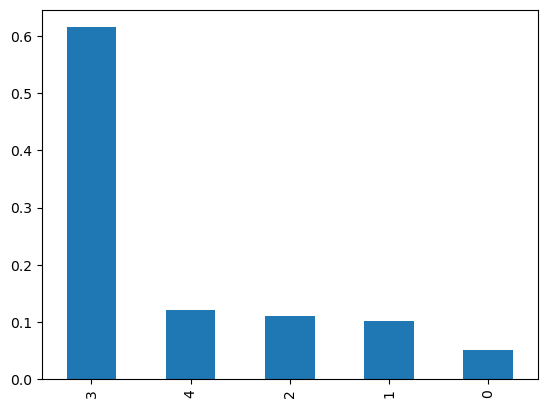

In [11]:
print('train data num: {}'.format(len(train_df)))
print('label num:')
print(train_df['label'].value_counts()/len(train_df))
(train_df['label'].value_counts()/len(train_df)).plot(kind='bar')

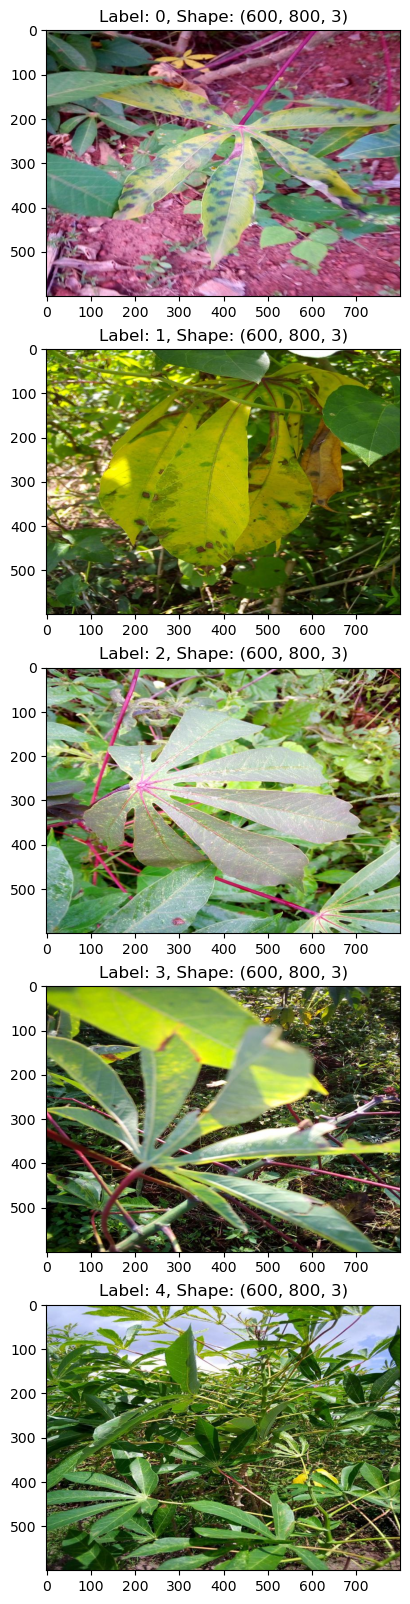

In [12]:
def plot_images(df, img_path, figsize=(30, 20)):
    fig = plt.figure(figsize=figsize)
    label_num = len(df['label'].unique())
    
    for i in range(label_num):
        ax = fig.add_subplot(label_num, 1, i+1)
        sample = df[df['label']==i]['image_id'].sample().reset_index(drop=True).iloc[0]
        img = cv2.imread(os.path.join(img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Label: {}, Shape: {}".format(i, img.shape))
    plt.show()
    
plot_images(train_df, train_img_path)

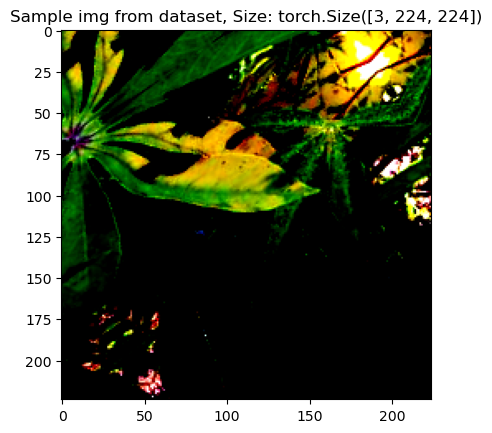

In [13]:
# create Dataset and Transform
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, data_img_path:str, phase:str="train", transform:object=None):
        self.df = df
        self.data_img_path = data_img_path
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        img = cv2.imread(os.path.join(self.data_img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img, self.phase)
            
        if self.phase == 'test':
            return img
        
        label = self.df['label'].iloc[idx]
        
        return img, label
    
class Transform(object):
    def __init__(self, scale_limit:list, crop_size:int, mean:float, std:float):
        self.transform = {
            'train':A.Compose([
                A.SmallestMaxSize(scale_limit),
                A.CenterCrop(crop_size, crop_size),
                A.VerticalFlip(),
                A.HorizontalFlip(),
                A.ShiftScaleRotate(),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'val':A.Compose([
                A.SmallestMaxSize(scale_limit[0]),
                A.CenterCrop(crop_size, crop_size),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.SmallestMaxSize(scale_limit[0]),
                A.CenterCrop(crop_size, crop_size),
                A.Normalize(mean, std),
                ToTensorV2()
            ])
        }
        
    def __call__(self, img, phase):
        return self.transform[phase](image=img)['image']
    
# test dataset and transform
# 短編をリサイズ、224にクロップ
scale_min, scale_max = 256, 480
scale_limit = [scale_min, scale_max]
crop_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(scale_limit, crop_size, mean, std)
dataset = CassavaDataset(train_df, train_img_path, 'train', transform)
img, label = dataset.__getitem__(0)
plt.imshow(img.numpy().transpose(1,2,0))
plt.title("Sample img from dataset, Size: {}".format(img.size()))
plt.show()

In [17]:
# create model 
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//reduction, channel, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        out = self.squeeze(x).view(b,c)
        out = self.fc(out).view(b,c,1,1)
        return x * out.expand_as(x)

def conv33(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

def conv11(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class ResidualLayer(nn.Module):
    expansion = 1
    def __init__(self, in_channels, channels, stride=1, se=True):
        super(ResidualLayer, self).__init__()
        self.conv1 = conv11(in_channels, channels, stride=stride)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv33(channels, channels)
        self.bn2 = nn.BatchNorm2d(channels)
        
        if in_channels != channels * self.expansion:
            self.shortcut = nn.Sequential(
                conv11(in_channels, channels*self.expansion, stride),
                nn.BatchNorm2d(channels*self.expansion)
            )
        else:
            self.shortcut = nn.Sequential()
            
        if se:
            self.se = SELayer(channels)
        else:
            self.se = nn.Sequential()
            
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        
        out += self.shortcut(x)
        
        out = self.relu(out)
        
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

        # 重みを初期化する。
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, channels, stride))

        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def resnet34():
    return ResNet(num_classes=10, block=ResidualLayer, layers=[3, 4, 6, 3])

model = resnet34()

In [ ]:
def train_model(model, dl_dict, optimizer, criterion, device, epochs, scheduler):
    since = time.time()
    best_acc = 0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.is_benchmark = True
        
    for epoch in range(epochs):
        print('Epoch{}/{}'.format(epoch+1, epochs))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dl_dict[phase]):
                model = model.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            
            epoch_loss = running_loss / len(dl_dict[phase].dataset)
            epoch_acc = running_corrects / len(dl_dict[phase].dataset)
            
            if phase == 'val' and scheduler != None:
                scheduler.step(epoch_loss)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_se-resnet34.pth')
        
        print("{} Loss: {:4f}, Acc: {:4f}".format(phase, epoch_loss, epoch_acc))
    
    time_elapced = time.time() - since
    print("Training complete: {}m {}s".format(time_elapced//60, time_elapced%60))
    print("Val best acc: {}".format(best_acc))
    
train, val = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df['label'])
traindataset = CassavaDataset(train, train_img_path, 'train', transform)
valdataset = CassavaDataset(val, train_img_path, 'val', transform)
train_dl = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=2)
val_dl = DataLoader(valdataset, batch_size=16, shuffle=False, num_workers=2)
dl_dict = {'train':train_dl, 'val':val_dl}

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, verbose=True)
criterion = nn.CrossEntropyLoss()
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, dl_dict, optimizer, criterion, device, epochs, scheduler)

Epoch1/50
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load(data_path, 'baseline-senet/best_senet.pth'))
model = model.to(device)
model.eval()

test_img_path = os.path.join(data_path,　'test_images')
test_df = pd.DataFrame(os.path.join(data_path, 'sample_submission'))
testdataset = CassavaDataset(test_df, test_img_path, 'test', transform)
testdl = DataLoader(testdataset, batch_size=16, shuffle=True, num_workers=2)

predictions = []
for inputs, labels in testdl:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predictions.append(preds)
    
test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv')